<a href="https://colab.research.google.com/github/ManasVardhan/Oil_Spill_Segmentation/blob/main/DID_IT_SPILL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf 
from tensorflow.keras.layers import *

In [ ]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

# Data Gathering



# Data Cleaning and creating data generators

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

!cp '/content/drive/MyDrive/Data_for_oil_spill/file.zip' Dataset

In [ ]:
!unzip /content/Dataset

Archive:  /content/Dataset
   creating: content/dataset/
   creating: content/dataset/test/
   creating: content/dataset/test/labels/
  inflating: content/dataset/test/labels/35_800,15_180_3.png  
  inflating: content/dataset/test/labels/40_152,24_961_3.png  
  inflating: content/dataset/test/labels/42_308,18_108_2.png  
  inflating: content/dataset/test/labels/42_460,29_653_7.png  
  inflating: content/dataset/test/labels/43_449,8_1454_11.png  
  inflating: content/dataset/test/labels/60_945,0_9989_21.png  
  inflating: content/dataset/test/labels/35_909,35_085_3.png  
  inflating: content/dataset/test/labels/39_948,2_2619_3.png  
  inflating: content/dataset/test/labels/40_152,24_961_5.png  
  inflating: content/dataset/test/labels/42_701,6_9163_1.png  
  inflating: content/dataset/test/labels/60_945,0_9989_5.png  
  inflating: content/dataset/test/labels/57_640,23_084_5.png  
  inflating: content/dataset/test/labels/35_909,35_085_4.png  
  inflating: content/dataset/test/labels/43_5

In [ ]:
for filename in os.listdir("/content/dataset/train/frames"):
    if '(' in str(filename):
        print(filename + " ... 1" )
        os.remove('/content/dataset/train/frames/'+str(filename))


for filename in os.listdir("/content/dataset/train/masks"):
    if '(' in str(filename):
        print(filename + " ... 2")
        os.remove('/content/dataset/train/masks/'+str(filename))


for filename in os.listdir("/content/dataset/test/images"):
    if '(' in str(filename):
        print(filename + " ... 3")
        os.remove('/content/dataset/test/images/'+str(filename))


for filename in os.listdir("/content/dataset/test/labels"):
    if '(' in str(filename):
        print(filename + " ... 4")
        os.remove('/content/dataset/test/labels/'+str(filename))


In [ ]:
drive.flush_and_unmount()

In [ ]:
#create dataset
def _read_to_tensor(fname, output_height=256, output_width=256, normalize_data=False):
    '''Function to read images from given image file path, and provide resized images as tensors
        Inputs: 
            fname - image file path
            output_height - required output image height
            output_width - required output image width
            normalize_data - if True, normalize data to be centered around 0 (mean 0, range 0 to 1)
        Output: Processed image tensors
    '''
    
    # Read the image as a tensor
    img_strings = tf.io.read_file(fname)
    imgs_decoded = tf.image.decode_jpeg(img_strings)
    
    # Resize the image
    output = tf.image.resize(imgs_decoded, [output_height, output_width])
    
    # Normalize if required
    if normalize_data:
        output = (output - 128) / 128
    return output



def read_images(img_dir):
    '''Function to get all image directories, read images and masks in separate
     tensors
        Inputs: 
            img_dir - file directory
        Outputs 
            frame_tensors, masks_tensors, frame files list, mask files list
    '''
    
    # Get the file names list from provided directory
    file_list = [f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f))]
    
    # Separate frame and mask files lists, exclude unnecessary files
    frames_list = [file for file in file_list if ('_L' not in file) and ('txt' not in file)]
    masks_list = [file for file in file_list if ('_L' in file) and ('txt' not in file)]
    
    print('{} frame files found in the provided directory.'.format(len(frames_list)))
    print('{} mask files found in the provided directory.'.format(len(masks_list)))
    
    # Create file paths from file names
    frames_paths = [os.path.join(img_dir, fname) for fname in frames_list]
    masks_paths = [os.path.join(img_dir, fname) for fname in masks_list]
    
    # Create dataset of tensors
    frame_data = tf.data.Dataset.from_tensor_slices(frames_paths)
    masks_data = tf.data.Dataset.from_tensor_slices(masks_paths)
    
    # Read images into the tensor dataset
    frame_tensors = frame_data.map(_read_to_tensor)
    masks_tensors = masks_data.map(_read_to_tensor)
    
    print('Completed importing {} frame images from the provided directory.'.format(len(frames_list)))
    print('Completed importing {} mask images from the provided directory.'.format(len(masks_list)))
    
    return frame_tensors, masks_tensors, frames_list, masks_list


In [ ]:
# Fit with data augmentation
batch_size = 32
data_generator = tf.preprocessing.image.ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(x_train, y_train, batch_size)
steps_per_epoch = x_train.shape[0] // batch_size
r = model.fit(train_generator, validation_data=(x_test, y_test), steps_per_epoch=steps_per_epoch, epochs=50)

AttributeError: ignored

# Defining Model arcitecture and training loops

In [ ]:

def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs, conv10)

    model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4 , beta_1=0.9, beta_2=0.999, epsilon=1e-07,), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model



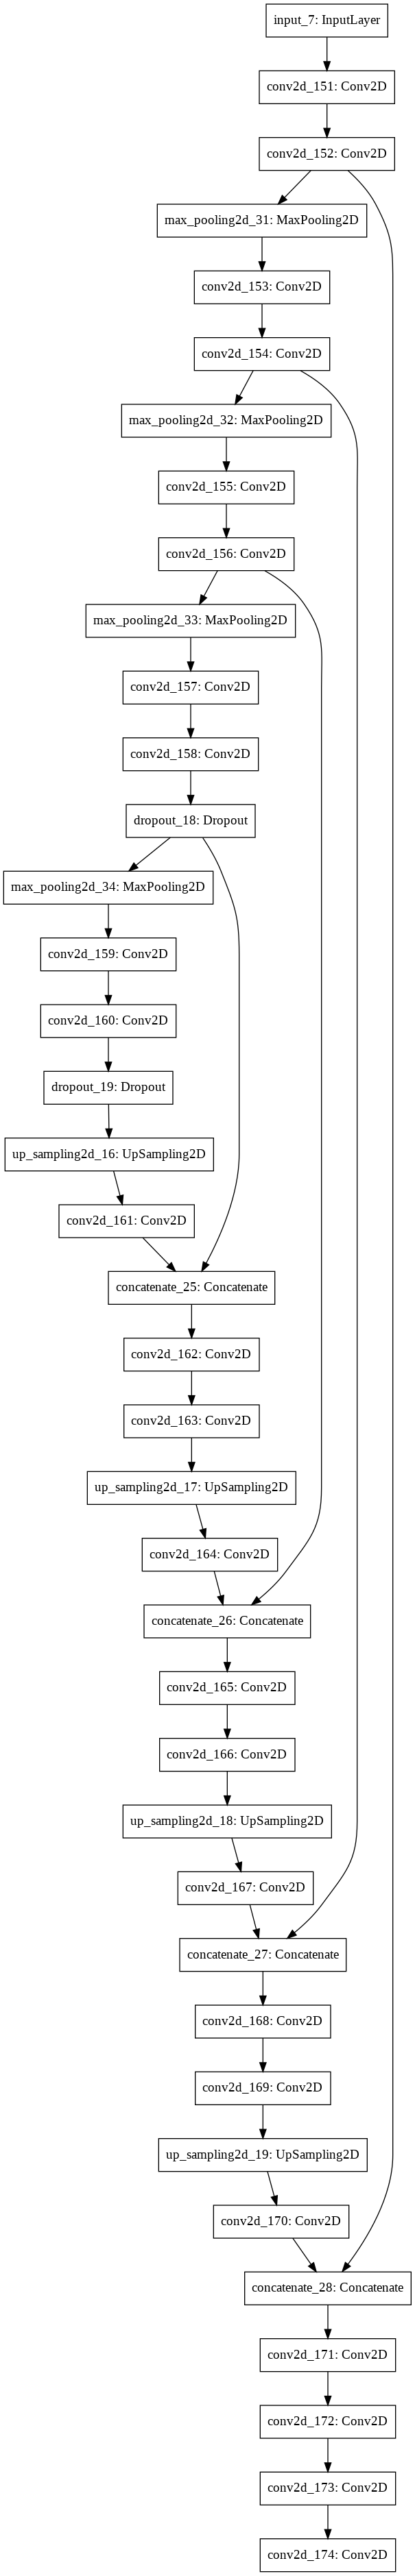

In [ ]:
ourModel = unet()
tf.keras.utils.plot_model(ourModel)

In [ ]:
#Adding Visualizations 

'''Add frame_tensors and mask tensors'''

# Make an iterator to extract images from the tensor dataset
frame_batches = tf.compat.v1.data.make_one_shot_iterator(frame_tensors)  
mask_batches = tf.compat.v1.data.make_one_shot_iterator(masks_tensors)

n_images_to_show = 5

for i in range(n_images_to_show):
    
    # Get the next image from iterator
    frame = frame_batches.next().numpy().astype(np.uint8)
    mask = mask_batches.next().numpy().astype(np.uint8)
    
    #Plot the corresponding frames and masks
    fig = plt.figure()
    fig.add_subplot(1,2,1)
    plt.imshow(frame)
    fig.add_subplot(1,2,2)
    plt.imshow(mask)
    plt.show()



# Training process 


# Hyper parameter tunning and fine-tunning 

In [ ]:
! pip install git+https://github.com/divamgupta/image-segmentation-keras


  Cloning https://github.com/divamgupta/image-segmentation-keras to /tmp/pip-req-build-2m14h6ld
  Running command git clone -q https://github.com/divamgupta/image-segmentation-keras /tmp/pip-req-build-2m14h6ld
     |████████████████████████████████| 3.3MB 5.9MB/s 
  Created wheel for keras-segmentation: filename=keras_segmentation-0.3.0-cp36-none-any.whl size=30543 sha256=942a1ebd987866559e60cb085a99f398d9b50470e33007736ca43a55fe760e60
  Stored in directory: /tmp/pip-ephem-wheel-cache-sl7p_kbv/wheels/a8/be/2c/1e1f0a75330e3ae33dd34c2ba085929eb7c7ae1d2184f4b7b5
Successfully built keras-segmentation
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: imageio 2.4.1
    Uninstalling imageio-2.4.1:
      Successfully uninstalled imageio-2.4.1


In [ ]:
from keras_segmentation.models.unet import vgg_unet

model = vgg_unet(n_classes=5 ,  input_height=640,input_width=1248  ) 


58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
model.train(
    train_images =  "/content/Oil Spill Detection Dataset/train/frames",
    train_annotations = "/content/Oil Spill Detection Dataset/train/masks",
    checkpoints_path = "/tmp/vgg_unet_1" , epochs=5  
)

Verifying training dataset
Found error during data loading
No corresponding segmentation found for image /content/Oil Spill Detection Dataset/train/frames/69_973,17_331_12.jpg.


AssertionError: ignored

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image

def resize_images(directory):
    i=0
    for filename in os.listdir(directory):
        # print(directory+'/'+filename)
        print(i)
        i=i+1
        img = cv2.imread(directory+'/'+filename)
        # print(img)
        res = cv2.resize(img, dsize=(1248, 640)) 
        im = Image.fromarray(res)
        im.save(directory+'/'+filename)

In [ ]:
resize_images('/content/dataset/train/frames')
print("========================")
resize_images('/content/dataset/train/masks')
print("========================")
resize_images('/content/dataset/test/images')
print("========================")
resize_images('/content/dataset/test/labels')
print("========================")


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib as plt 
def convert_pixel(filename):
    img=cv2.imread(filename)
    lower_range_black = np.array([-1,-1,-1])
    upper_range_black = np.array([1,1,1])
    lower_range_cyan  = np.array([-1,254, 254])
    upper_range_cyan  = np.array([1,256, 256])
    lower_range_red = np.array([254,-1,-1])
    upper_range_red = np.array([256,1,1])
    lower_range_brown = np.array([152,75,-1])
    upper_range_brown = np.array([154,77,1])
    lower_range_green = np.array([-1,152,-1])
    upper_range_green = np.array([1,154,1])
    

    mask_black = cv2.inRange(img, lower_range_black, upper_range_black)
    mask_cyan = cv2.inRange(img, lower_range_cyan, upper_range_cyan)
    mask_red = cv2.inRange(img, lower_range_red, upper_range_red)
    mask_brown = cv2.inRange(img, lower_range_brown, upper_range_brown)
    mask_green = cv2.inRange(img, lower_range_green, upper_range_green)
    
    final_mask = mask_black + mask_brown + mask_cyan + mask_green + mask_red
    arr = [[0, 0, 0],[0, 255, 255],[255,0,0],[153, 76, 0],[0, 153, 0]]
    for i in range(final_mask.shape[0]):
        for j in range(final_mask.shape[1]) :
            if img[i][j].tolist() not in arr:
                img[i][j] = [0,0,0]

    # x = (np.unique(img.reshape(-1, img.shape[2]), axis=0))
    # cv2_imshow(img)
    # print(len(x))
    return img



In [ ]:
# Cleaning dataset 

a = 0
# directory = '/content/dataset/test/labels/'
directory = '/content/content/dataset/train/masks'


for i in os.listdir(directory):
    a=a+1
    imgdir = directory+''+i
    
    img = convert_pixel(imgdir)
    # print(img)
    cv2.imwrite(imgdir, img) 
    # im = Image.fromarray(img)
    # im.save(directory+'/'+filename)
    x = (np.unique(img.reshape(-1, img.shape[2]), axis=0))
    print(imgdir + " ======= " + str(len(x)))
    
print(a)


NameError: ignored

In [ ]:
!zip -r "/content/file.zip" "/content/dataset"


In [ ]:
from google.colab import files
files.download("/content/file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib as plt 
def convert_to_GRAY(filename):
    img=cv2.imread(filename)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]) :
            if img[i][j].tolist() == [0,0,0]:
                img[i][j] = [0,0,0]
            if img[i][j].tolist() == [0, 255, 255]:
                img[i][j] = [1,1,1]
            if img[i][j].tolist() == [255,0,0]:
                img[i][j] = [2,2,2]
            if img[i][j].tolist() == [153, 76, 0]:
                img[i][j] = [3,3,3]
            if img[i][j].tolist() == [0, 153, 0]:
                img[i][j] = [4,4,4]

    # x = (np.unique(img.reshape(-1, img.shape[2]), axis=0))
    # cv2_imshow(img)
    # print(len(x))
    return img
#a=convert_to_GRAY('/content/dataset/train/masks/27_884,-17_39_2.png')


In [ ]:
# loop for changing colors in dataset 

a = 0
# directory = '/content/dataset/test/labels/'
directory = '/content/content/dataset/train/masks/'


for i in os.listdir(directory):
    a=a+1
    imgdir = directory+''+i
    
    img = convert_to_GRAY(imgdir)
    # print(img)
    cv2.imwrite(imgdir, img) 
    # im = Image.fromarray(img)
    # im.save(directory+'/'+filename)
    x = (np.unique(img.reshape(-1, img.shape[2]), axis=0))
    print(str(a) + " == " + imgdir + " ======= " + str(len(x)))
    


1 == /content/content/dataset/train/masks/51_751,2_1743_4.png ======= 2
2 == /content/content/dataset/train/masks/55_526,5_0506_4.png ======= 3
3 == /content/content/dataset/train/masks/52_351,3_2041_2.png ======= 2
4 == /content/content/dataset/train/masks/56_442,2_2855_2.png ======= 4
5 == /content/content/dataset/train/masks/71_103,22_728_4.png ======= 2
6 == /content/content/dataset/train/masks/44_424,13_103_6.png ======= 2
7 == /content/content/dataset/train/masks/33_540,14_508_3.png ======= 2
8 == /content/content/dataset/train/masks/38_690,11_816_4.png ======= 3
9 == /content/content/dataset/train/masks/40_026,18_753_3.png ======= 3
10 == /content/content/dataset/train/masks/38_003,4_2111_1.png ======= 2
11 == /content/content/dataset/train/masks/43_157,8_6386_2.png ======= 2
12 == /content/content/dataset/train/masks/69_406,33_683_3.png ======= 3
13 == /content/content/dataset/train/masks/34_815,35_138_12.png ======= 2
14 == /content/content/dataset/train/masks/54_027,5_0900_3.

In [ ]:
# checking dataset 

directory = '/content/Oil_Spill_Detection_Dataset/train/masks/'
for i in os.listdir(directory):
    imgdir = directory+''+i
    
    img = cv2.imread(imgdir)
 
    x = (np.unique(img.reshape(-1, img.shape[2]), axis=0))
    print(i + " ======= " + str(len(x)))
    


33_930,12_594_2.png ======= 4
56_137,-0_433_6.png ======= 2
31_512,32_484_1.png ======= 4
51_751,2_1743_6.png ======= 3
34_990,29_492_2.png ======= 2
36_602,15_854_1.png ======= 4
57_057,0_8651_1.png ======= 3
35_807,29_503_8.png ======= 2
37_110,20_875_1.png ======= 4
37_042,-1_328_3.png ======= 3
36_602,15_854_3.png ======= 2
40_732,1_8561_2.png ======= 2
44_424,13_103_7.png ======= 3
73_907,20_793_4.png ======= 2
54_954,13_319_7.png ======= 2
35_249,31_143_1.png ======= 2
36_425,11_725_4.png ======= 2
39_396,0_7409_3.png ======= 2
71_092,31_225_3.png ======= 2
61_296,0_9444_4.png ======= 3
73_915,31_368_5.png ======= 2
49_412,-0_183_2.png ======= 2
71_252,20_966_8.png ======= 2
58_415,-0_197_3.png ======= 3
31_459,32_511_1.png ======= 4
51_816,2_4740_1.png ======= 2
36_992,13_438_4.png ======= 4
41_737,10_558_1.png ======= 3
35_320,29_685_5.png ======= 2
56_442,2_2855_3.png ======= 4
56_155,12_412_3.png ======= 5
55_340,14_838_2.png ======= 4
27_884,-17_39_2.png ======= 5
54_836,19_

In [ ]:
!zip -r '/content/file.zip' '/content/Oil_Spill_Detection_Dataset'


  adding: content/Oil_Spill_Detection_Dataset/ (stored 0%)
  adding: content/Oil_Spill_Detection_Dataset/test/ (stored 0%)
  adding: content/Oil_Spill_Detection_Dataset/test/labels_1D/ (stored 0%)
  adding: content/Oil_Spill_Detection_Dataset/test/labels_1D/42_460,29_653_3.png (deflated 29%)
  adding: content/Oil_Spill_Detection_Dataset/test/labels_1D/56_274,18_198_2.png (deflated 41%)
  adding: content/Oil_Spill_Detection_Dataset/test/labels_1D/40_281,7_2336_3.png (deflated 45%)
  adding: content/Oil_Spill_Detection_Dataset/test/labels_1D/43_449,8_1454_5.png (deflated 20%)
  adding: content/Oil_Spill_Detection_Dataset/test/labels_1D/58_706,19_541_1.png (deflated 20%)
  adding: content/Oil_Spill_Detection_Dataset/test/labels_1D/42_071,41_151_2.png (deflated 31%)
  adding: content/Oil_Spill_Detection_Dataset/test/labels_1D/42_308,18_108_3.png (deflated 8%)
  adding: content/Oil_Spill_Detection_Dataset/test/labels_1D/35_909,35_085_4.png (deflated 2%)
  adding: content/Oil_Spill_Detection

In [ ]:
!zip -r /content/content/datasetzip /content/content/dataset

  adding: content/content/dataset/ (stored 0%)
  adding: content/content/dataset/train/ (stored 0%)
  adding: content/content/dataset/train/masks/ (stored 0%)
  adding: content/content/dataset/train/masks/51_751,2_1743_4.png (deflated 42%)
  adding: content/content/dataset/train/masks/55_526,5_0506_4.png (deflated 56%)
  adding: content/content/dataset/train/masks/52_351,3_2041_2.png (deflated 65%)
  adding: content/content/dataset/train/masks/56_442,2_2855_2.png (deflated 45%)
  adding: content/content/dataset/train/masks/71_103,22_728_4.png (deflated 33%)
  adding: content/content/dataset/train/masks/44_424,13_103_6.png (deflated 36%)
  adding: content/content/dataset/train/masks/33_540,14_508_3.png (deflated 73%)
  adding: content/content/dataset/train/masks/38_690,11_816_4.png (deflated 52%)
  adding: content/content/dataset/train/masks/40_026,18_753_3.png (deflated 39%)
  adding: content/content/dataset/train/masks/38_003,4_2111_1.png (deflated 67%)
  adding: content/content/datas